In [37]:
import camb
import healpy as hp
import pysm3
import pysm3.units as u
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import pickle as pl
import time
from pysm3 import units as u
import numpy as np
from pysm3.models.dust import blackbody_ratio
from pysm3.utils import bandpass_unit_conversion, normalize_weights, trapz_step_inplace

In [38]:
nside = 128

In [39]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,  As=2e-9, ns=0.965, halofit_version='mead', lmax=7000)
results = camb.get_results(pars)
lensed_cl = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['lensed_scalar']
cmb_map = hp.synfast(lensed_cl.T, nside=nside, new=True)

In [40]:
freqs = np.array(["27", "39", "93", "145", "225", "280"])
fwhm = np.array([7.4, 5.1, 2.2, 1.4, 1.0, 0.9])
nlev_p = np.array([23.6, 13.1, 2.3, 2.2, 4.8, 2.2])

In [41]:
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1"])

In [42]:
def noise_map(nside,nlev_p):
    nl_p = np.ones(3*nside) * np.radians(nlev_p / 60.)**2
    nlev_t = nlev_p / np.sqrt(2)
    nl_t = np.ones(3*nside) * np.radians(nlev_t / 60.)**2
    cl_s = [nl_t, nl_p, nl_p, nl_p*0]
    return hp.synfast(cl_s, nside=nside, new=True)

def sky_map_wfg(freqs, fwhm, nlev_p, nside):
    maps = []
    for i in tqdm(range(len(freqs))):
        fg = sky.get_emission(int(freqs[i])*u.GHz)
        fg = fg.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(int(freqs[i])*u.GHz))
        signal = cmb_map + fg.value
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        noise = noise_map(nside, nlev_p[i])
        maps.append(signal + noise)
    return maps
def sky_map_wofg(freqs, fwhm, nlev_p, nside):
    maps = []
    for i in tqdm(range(len(freqs))):
        signal = cmb_map
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        noise = noise_map(nside, nlev_p[i])
        maps.append(signal + noise)
    return maps

In [43]:
sky_maps = sky_map_wfg(freqs, fwhm, nlev_p, nside)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


In [44]:
sys.path.append('../')

In [45]:
%load_ext autoreload
%autoreload 2
from pynilc.nilc import NILC
from pynilc.needlets import NeedletTransform
from pynilc.sht import HealpixDUCC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
bandcenters = np.array([0,100,200,250])
nfilters = NeedletTransform.CosineNeedlet(bandcenters,lmax=256)

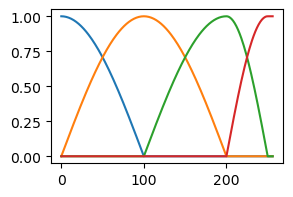

In [47]:
plt.figure(figsize=(3,2))
for i in range(len(nfilters)):
    plt.plot(nfilters[i])

In [48]:
Bmap = hp.alm2map(hp.map2alm(cmb_map)[2], nside=nside)

In [49]:
#nilc_hp = NILC(freqs, fwhm, nfilters, backend='healpy')
# nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,common_fwhm=10)

In [50]:
# ilc_map_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=0)

In [51]:
# nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside)
# ilc_emap_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=1)

In [52]:
nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,required_num_modes=500)
ilc_bmap_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=2)

Level 1 parallel processing is enabled
Computing B-mode alms


Computing alms:   0%|          | 0/6 [00:00<?, ?it/s]

Processing Needlet Scales: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


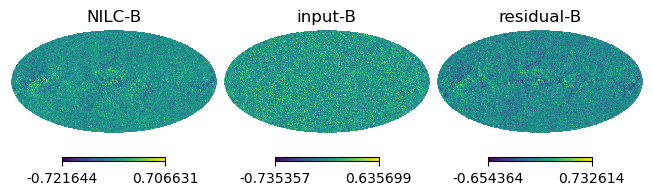

In [53]:
hp.mollview(ilc_bmap_dc, title='NILC-B',sub=(1,3,1))
hp.mollview(Bmap, title='input-B',sub=(1,3,2))
hp.mollview(ilc_bmap_dc-Bmap, title='residual-B',sub=(1,3,3))

In [54]:
def arc2cl(arc):
    return np.radians(arc/60)**2
def cl2arc(cl):
    return np.rad2deg(np.sqrt(cl))*60
def noise(arr):
    return cl2arc(1/sum(1/arc2cl(arr)))

In [55]:
cl = hp.anafast(ilc_bmap_dc)

In [56]:
bl = hp.gauss_beam(fwhm=np.radians(10/60), lmax=len(cl)-1)

(1e-08, 0.0001)

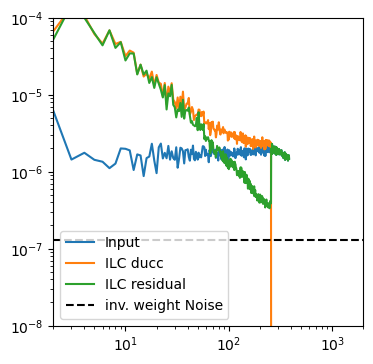

In [57]:
plt.figure(figsize=(4,4))
plt.loglog(hp.anafast(Bmap), label='Input')
plt.loglog(cl, label='ILC ducc')
plt.loglog(hp.anafast(Bmap-ilc_bmap_dc), label='ILC residual')
plt.axhline(arc2cl(noise(nlev_p)), color='k', ls='--', label='inv. weight Noise')
plt.loglog()
plt.legend()
plt.xlim(2, 2000)
plt.ylim(1e-8, 1e-4)

In [58]:
noise_maps = []
for i in range(len(freqs)):
    noise_maps.append(noise_map(nside, nlev_p[i]))

In [59]:
ilc_noise = nilc_dc.calculate_residuals(noise_maps, ilc_weights_dc,field=2)

Computing B-mode alms


Calculating residuals: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


(1e-08, 0.0001)

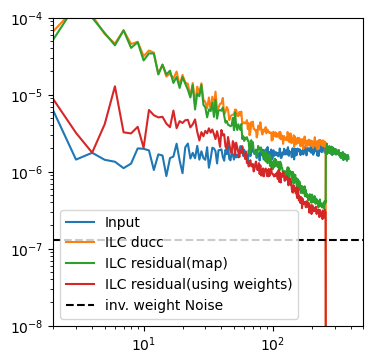

In [60]:
plt.figure(figsize=(4,4))
plt.loglog(hp.anafast(Bmap), label='Input')
plt.loglog(hp.anafast(ilc_bmap_dc), label='ILC ducc')
plt.loglog(hp.anafast(Bmap-ilc_bmap_dc), label='ILC residual(map)')
plt.loglog(hp.anafast(ilc_noise), label='ILC residual(using weights)') #Noise realizations are not the same as the ones used in the NILC
plt.axhline(arc2cl(noise(nlev_p)), color='k', ls='--', label='inv. weight Noise')
plt.loglog()
plt.legend()
plt.xlim(2, 500)
plt.ylim(1e-8, 1e-4)

In [61]:
nilc_fg = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside)

Level 1 parallel processing is enabled


In [62]:
sky_maps_fg = sky_map_wfg(freqs, fwhm, nlev_p, nside)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:18<00:00,  3.14s/it]


In [63]:
ilc_map_fg, ilc_weights_fg = nilc_fg.component_separation(sky_maps_fg,field=2)

Computing B-mode alms


Processing Needlet Scales: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


(1e-08, 0.0001)

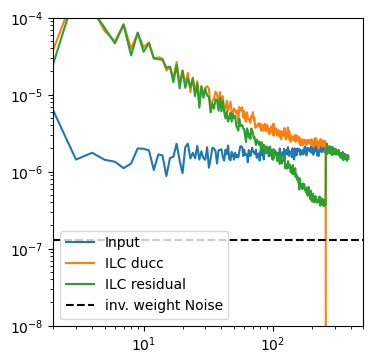

In [64]:
plt.figure(figsize=(4,4))
plt.loglog(hp.anafast(Bmap), label='Input')
plt.loglog(hp.anafast(ilc_map_fg), label='ILC ducc')
plt.loglog(hp.anafast(Bmap-ilc_map_fg), label='ILC residual')
plt.axhline(arc2cl(noise(nlev_p)), color='k', ls='--', label='inv. weight Noise')
plt.loglog()
plt.legend()
plt.xlim(2, 500)
plt.ylim(1e-8, 1e-4)

In [65]:
input_alms = []
for i in tqdm(range(len(freqs))):
    input_alms.append(hp.map2alm(sky_maps[i])[2])
input_alms = np.array([input_alms])

100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


In [70]:
input_alms = input_alms.reshape((6,1,73920))

In [71]:
input_alms.shape

(6, 1, 73920)

In [72]:


def _get_local_cov_(map1: np.ndarray, map2: np.ndarray, pps: float, nside_covar = None, reduce_bias = False) -> np.ndarray:
    if hp.get_nside(map1) != hp.get_nside(map2):
        raise ValueError("Input maps must have the same HEALPix resolution.")
    product_map = map1 * map2
    npix = product_map.size
    nside = hp.get_nside(product_map)
    if nside_covar is None:
        nside_covar = nside

    # Degrade resolution for faster smoothing
    nside_out = max(1, nside // 4)
    stat_map = hp.ud_grade(product_map, nside_out = nside_out, order_in = 'RING', order_out = 'RING')
    
    # Compute alm
    lmax_stat = 2 * nside_out #3 * nside_out - 1 # 
    alm_s = hp.map2alm(stat_map, lmax=lmax_stat, iter=1, use_weights=True)# iter=0?

    # Get beam for smoothing covariance
    pix_size = np.sqrt(4.0 * np.pi / npix)
    fwhm_stat = pps * pix_size
    bl_stat = hp.gauss_beam(fwhm_stat, lmax_stat)

    # If reduce_bias is True, apply bias reduction technique
    if reduce_bias:
        thetas = np.arange(0,np.pi,0.002)
        beam_stat = hp.bl2beam(bl_stat, thetas)
        theta_ = 0.5 * fwhm_stat
        dist = 0.5 * (np.tanh(30 * (thetas - 0.3 * theta_)) - np.tanh(30 * (thetas - 3 * theta_)))
        dist /= np.max(dist)
        dist[np.argmax(dist):]=1.
        bl_stat = hp.beam2bl(dist * beam_stat,thetas, lmax = lmax_stat)

    alm_s = hp.almxfl(alm_s, bl_stat)
    
    return hp.alm2map(alm_s, nside_covar, lmax=lmax_stat)

def _get_local_cov( input_maps,lmax, ilc_bias, b_ell = None, mask = None, reduce_bias = False, input_maps_2 = None) -> np.ndarray:

    if not isinstance(b_ell, np.ndarray):
        b_ell = np.ones(lmax+1)

    nmodes_band = np.sum((2. * np.arange(lmax + 1) + 1.) * (b_ell ** 2))
    pps = np.sqrt(float(input_maps.shape[1]) * float(input_maps.shape[0]-1) / (ilc_bias * nmodes_band) )

    n_channels = input_maps.shape[0]
    nside_cov = hp.npix2nside(input_maps.shape[1]) if mask is not None else int(np.min([hp.npix2nside(input_maps.shape[1]), 128]))

    cov = np.zeros((n_channels, n_channels, 12 * nside_cov ** 2))

    for i in range(n_channels):
        for k in range(i,n_channels):
            map1 = input_maps[i] * mask if mask is not None else input_maps[i]
            map2 = (input_maps_2[k] if input_maps_2 is not None else input_maps[k])
            map2 = map2 * mask if mask is not None else map2

            cov[i,k] = cov_map = _get_local_cov_(
                map1, map2, pps, nside_cov, reduce_bias=reduce_bias
            )

    for i in range(n_channels):
        for k in range(i):
            cov[i,k]=cov[k,i]
            
    return cov

def get_ilc_cov( input_maps, lmax, b_ell, mask = None, ilc_bias=0, reduce_bias=False): #compsep_run: Dict, b_ell: np.ndarray ) -> np.ndarray:
    if ilc_bias == 0.:
        if mask is not None:
            cov=np.mean(np.einsum('ik,jk->ijk', (input_maps * mask)[:, mask > 0.], (input_maps * mask)[:, mask > 0.]),axis=-1)
        else:
            cov=np.mean(np.einsum('ik,jk->ijk', input_maps, input_maps),axis=-1)
    else:
        cov = _get_local_cov(
            input_maps, lmax, ilc_bias, b_ell=b_ell,
            mask=mask, reduce_bias=reduce_bias
        )
        if mask is not None and cov.shape[-1] == input_maps.shape[-1]:
                cov = np.copy(cov[...,mask > 0.])
    return cov

def get_inv_cov(cov: np.ndarray) -> np.ndarray:
    if cov.ndim == 2:
        inv_cov=np.linalg.inv(cov)
    elif cov.ndim == 3:
        inv_cov=np.linalg.inv(cov.T).T
    return inv_cov


def get_ilc_weights( A_cmb, inv_cov, input_shapes, ilc_bias=0, mask=None) -> np.ndarray:

    if ilc_bias == 0.:
        w_ilc = (A_cmb.T @ inv_cov) / (A_cmb.T @ inv_cov @ A_cmb) 
    else:
        w_ilc=np.zeros((input_shapes[0],input_shapes[-2]))
        AT_invC = np.einsum('j,ijk->ik', A_cmb, inv_cov) # np.sum(inv_cov,axis=1)
        AT_invC_A = np.einsum('j,ijk, i->k', A_cmb, inv_cov, A_cmb) #np.sum(inv_cov,axis=(0,1))
        for i in range(input_shapes[0]):
            if mask is not None:
                w_ilc[i, mask > 0.] = AT_invC[i]/AT_invC_A
            else:
                w_ilc[i]=hp.ud_grade(AT_invC[i]/AT_invC_A,hp.npix2nside(input_shapes[-2]))
    return w_ilc


In [73]:

def _needlet_filtering(alms: np.ndarray, b_ell: np.ndarray, lmax_out: int) -> np.ndarray:

    if alms.ndim == 2:
        filtered_alms = np.array([hp.almxfl(alms[:,c], b_ell) for c in range(alms.shape[-1])]).T
    elif alms.ndim == 1:
        filtered_alms = hp.almxfl(alms, b_ell)

    if alms.shape[0] == hp.Alm.getsize(lmax_out):
        return filtered_alms
    else:
        lmax_j = min(hp.Alm.getlmax(alms.shape[0]), lmax_out)
        idx_lmax_in = np.array([hp.Alm.getidx(hp.Alm.getlmax(filtered_alms.shape[0]), ell, m) for ell in range(0, lmax_j+1) for m in range(ell + 1)])
        idx_lmax_out = np.array([hp.Alm.getidx(lmax_out, ell, m) for ell in range(0, lmax_j+1) for m in range(ell + 1)])
        if alms.ndim == 2:
            alms_j = np.zeros((hp.Alm.getsize(lmax_out), alms.shape[-1]), dtype=complex)
            alms_j[idx_lmax_out, :] = filtered_alms[idx_lmax_in, :]
        elif alms.ndim == 1:
            alms_j = np.zeros((hp.Alm.getsize(lmax_out)), dtype=complex)
            alms_j[idx_lmax_out] = filtered_alms[idx_lmax_in]
        return alms_j

def _get_good_channels_nl(fwhms,fwhm_out,lmax, b_ell, threshold= 1e-5) -> np.ndarray:

    freqs_nl = []
    for i, fwhm in enumerate(fwhms):
        bl_in = hp.gauss_beam(np.radians(fwhm/60.), lmax=lmax,pol=False)
        bl_out = hp.gauss_beam(np.radians(fwhm_out/60.), lmax=lmax,pol=False)
        if not np.any((bl_in / bl_out)[b_ell > 1e-2] < threshold):
            freqs_nl.append(i)
    return np.array(freqs_nl)

    

def _ilc_maps(freqs, fwhms,fwhm_out,lmax, input_maps, b_ell,ilc_bias,mask=None) -> np.ndarray:

    good_channels = _get_good_channels_nl(fwhms,fwhm_out,lmax, b_ell)
    freqs = np.array(freqs)[good_channels]

    A_cmb = np.ones(freqs.shape)

    cov = get_ilc_cov(input_maps[...,0], lmax, b_ell, mask)

    inv_cov = get_inv_cov(cov)
    del cov

    w_ilc = get_ilc_weights(A_cmb, inv_cov, input_maps.shape, ilc_bias=0, mask=None)
    del inv_cov

    if ilc_bias == 0.:
        output_maps = np.einsum('i,ijk->jk', w_ilc, input_maps)
    else:
        output_maps = np.einsum('ij,ijk->jk', w_ilc, input_maps)

    return output_maps

def _get_nside_lmax_from_b_ell(b_ell: np.ndarray, nside: int, lmax: int):
    
    max_b = np.max(np.nonzero(b_ell)) 
    if max_b == lmax:
        return nside, lmax
    
    max_b = max_b / 2

    # If the band is non zero only for ell <= 16, nside and lmax are set to 8 and 16
    if max_b <= 8:
        return 8, 16
    
    for k in range(3, 12):
        lower, upper = 2**k, 2**(k + 1)
        if lower < max_b <= upper:
            if upper <= nside:
                return upper, 2 * upper
            else:
                return nside, 2 * nside
    return nside, lmax

def _ilc_needlet_j(input_alms,b_ell,nside,lmax,fwhms,fwhm_out,mask=None,adapt_nside=True,ilc_bias=0):
    #    config: Configs, input_alms: np.ndarray, compsep_run: Dict, b_ell: np.ndarray, nl_scale: int, **kwargs: Any):

    if mask is not None:
        nside_, lmax_ = nside, lmax
    else:
        if adapt_nside:
            nside_, lmax_ = _get_nside_lmax_from_b_ell(b_ell,nside,lmax)
        else:
            nside_, lmax_ = nside, lmax
    
    # Get frequency channels to be adopted in component separation at this scale
    good_channels_nl = _get_good_channels_nl(fwhms,fwhm_out,lmax, b_ell,)

    input_maps_nl = np.zeros((good_channels_nl.shape[0], 12 * nside_**2, input_alms.shape[-1]))
    for n, channel in enumerate(good_channels_nl):
        input_alms_j = _needlet_filtering(input_alms[channel], b_ell, lmax_)
        input_maps_nl[n] = np.array(
            [hp.alm2map(np.ascontiguousarray(input_alms_j[:, c]), nside_, lmax=lmax_, pol=False)
                for c in range(input_alms.shape[-1])]).T

    output_maps_nl = _ilc_maps(freqs, fwhms,fwhm_out,lmax,input_maps_nl,b_ell, ilc_bias=ilc_bias, mask=mask)

    del input_maps_nl

    output_alms_nl = np.array(
        [hp.map2alm(output_maps_nl[:, c], lmax=lmax_, pol=False) for c in range(output_maps_nl.shape[-1])]
    ).T

 
    output_alms_j = _needlet_filtering(output_alms_nl, b_ell[:lmax_+1], lmax)
        
    return output_alms_j

In [74]:
input_alms.shape

(6, 1, 73920)

In [75]:
output_alms = np.zeros((input_alms.shape[1], input_alms.shape[-1]), dtype=complex)
for j in range(nfilters.shape[0]):
    output_alms += _ilc_needlet_j(input_alms, nfilters[j],nside,256,fwhm,30)
    
    output_maps = np.array(
        [hp.alm2map(np.ascontiguousarray(output_alms[:, c]), nside, lmax=256, pol=False, pixwin=True)
            for c in range(input_alms.shape[-1])]).T

KeyboardInterrupt: 